# Subreddits Classification

# Project Outlook

1. Gather data from Reddit
2. Preprocess the data
3. Split into train/test sets
4. Modeling
5. Evaluation

In [1]:
import configparser
import json
import os
import random
import re
from collections import Counter

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import praw
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (Dense, Dropout, Embedding,
                                     GlobalAveragePooling1D)
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm.notebook import tqdm


In [2]:
mpl.style.use('seaborn')

In [3]:
TOPICS = [
    'entertainment',
    'python',
    'science',
    'gaming',
    'books',
    'technology',
    'music',
    'politics',
    'sports',
    'travel',
]

if not os.path.exists('data'):
    os.makedirs('data')

if not os.path.exists('models'):
    os.makedirs('models')

if not os.path.exists('results'):
    os.makedirs('results')

DATA_PATH = os.path.join('data', 'data.json')
MODEL_PATH = os.path.join('models', 'model.h5')
PREDICTIONS_PATH = os.path.join('results', 'predictions.csv')
GROUP_PREDICTIONS_PATH = os.path.join('results', 'group_predictions.csv')

# Getting the data

Reddit has an API we can use for this task, we'll put our credentials in the `config.ini` file, create an instance of the API client, request the subreddits we want and write the data to a `json` file in the following format:

[
    'subreddit': 'gaming',
    'label': 3,
    'text': 'I keep working on this game where you pilot cargo ships on a full-scale planet with realistic physics. (it's called Flight Of Nova)'
]

We're gonna use the `text` to classify the subreddit.

NOTE
----

Some subreddits contain more characters than others, some have a body and some only a title, I decided to concatenate the `title` + `body` to create the `text` field of each JSON object.

In [4]:
def get_config():
    '''Retrieves the config file and parses it into JSON format'''
    config = configparser.ConfigParser()
    config.read('config.ini')
    config = config['REDDIT_API']
    return config

In [5]:
def get_data(n_posts=1000):
    # API Credentials
    config = get_config()
    
    reddit = praw.Reddit(
        client_id=config.get('client_id'),
        client_secret=config.get('secret'),
        username=config.get('username'),
        password=config.get('password'),
        user_agent='exercise'
    )

    data = []

    for topic in tqdm(TOPICS):
        subreddit = reddit.subreddit(topic)
        
        # Use hot posts
        # hot_posts subreddit.hot(limit=n_posts)

        # Or top posts
        top_posts = subreddit.top(limit=n_posts)
        
        for post in top_posts:
            text = post.title + ' ' + post.selftext
            data.append({
                    'subreddit': subreddit.display_name,
                    'label': TOPICS.index(topic),
                    'post': text,
                })

    random.shuffle(data)  # Shuffle the data
    
    # Save to file
    with open(DATA_PATH, 'w') as f:
        json.dump(data, f)

    print('DATA HAS BEEN SAVED TO PATH: {}'.format(DATA_PATH))
    

In [6]:
if not os.path.exists(DATA_PATH):
    get_data()

## Now our data is saved in `data/data.json`, next we will pre-process it.

1. Removing special characters
2. Convert text to lowercase
3. Remove punctuation
4. Remove stop words
5. Tokenization (represent words as integers)

In [7]:
def load_data():
    with open(DATA_PATH, 'r') as f:
        data = json.load(f)
    return data

In [8]:
data = load_data()

# I'll put the data in a DataFrame so it'll be nicer to see what it contains
data_df = pd.DataFrame(data)
data_df

,subreddit,label,post
0,python,1,"Python patch, first try."
1,books,4,Kids Practice Reading to Shy Shelter Dogs at H...
2,sports,8,Miami and Duke played a football game on Slip ...
3,travel,9,"Heading to Shangri-La, China on a mystical ani..."
4,travel,9,Lived in the UK for 23 years and I visited Cor...
...,...,...,...
9917,entertainment,0,Britney Spears called 911 to report herself as...
9918,travel,9,View from the London Eye
9919,science,2,Parents who force unremorseful kids to apologi...
9920,science,2,The American Dream is slowly fading away as re...


In [9]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9922 entries, 0 to 9921
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9922 non-null   object
 1   label      9922 non-null   int64 
 2   post       9922 non-null   object
dtypes: int64(1), object(2)
memory usage: 232.7+ KB


In [10]:
# Example of the raw text

data_df.sample()['post'].iloc[0]

'I created a plague doctor sculpture in Minecraft, I think it turned out pretty good! '

<AxesSubplot:>

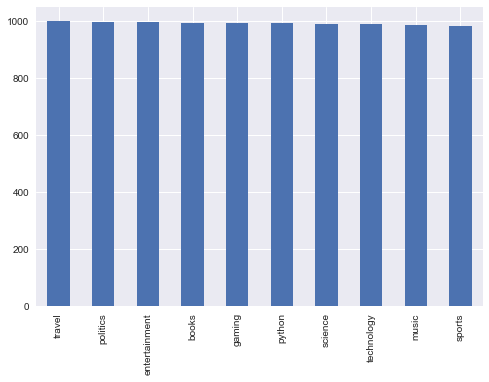

In [11]:
# The data is equally distributed in terms of classes

data_df['subreddit'].value_counts().plot(kind='bar')

## Now we will split each item in the data to `text` and `label`

In [12]:
def parse_data(data):
    texts = [post['post'] for post in data]
    labels = [post['label'] for post in data]
    
    return texts, labels

In [13]:
texts, labels = parse_data(data)

print(texts[0])
print(labels[0], TOPICS[labels[0]])

Python patch, first try. 
1 python


## Now let's clean the texts

In [14]:
def clean_text(text):
    '''Clean sentences, remove punctuation, convert to lowercase, split and remove stopwords'''
    text = re.sub("[^a-zA-Z]", ' ', text)
    text = text.lower().split()
    swords = set(stopwords.words("english"))
    swords.add('https')
    text = [word for word in text if word not in swords]
    text = " ".join(text)

    return text

In [15]:
texts_cleaned = list(map(clean_text, texts))

# Dirty
print(texts[0])

# Clean
print(texts_cleaned[0])

Python patch, first try. 
python patch first try


In [16]:
# Word frequency

counter = Counter()
texts_cleaned_splitted = list(map(str.split, texts_cleaned))

for text in texts_cleaned_splitted:
    counter.update(text)

word_freq = pd.Series(counter).sort_values(ascending=False)

word_freq

com           5979
trump         3437
www           2675
python        1457
new           1215
              ... 
navigate         1
hoopla           1
goof             1
fresher          1
glorifying       1
Length: 27451, dtype: int64

# Now we will split the data to train/test sets

In [17]:
def train_test_split(texts, labels, train_size=0.8):
    train_size = int(len(texts) * train_size)
    
    # Train
    train_texts = texts[:train_size]
    train_labels = labels[:train_size]

    # Test
    test_texts = texts[train_size:]
    test_labels = labels[train_size:]

    return (train_texts, train_labels), (test_texts, test_labels)

In [18]:
(train_texts, train_labels), (test_texts, test_labels) = train_test_split(texts_cleaned, labels)

In [19]:
# Inspect length of train set and test set
print('Training:', len(train_texts), len(train_labels))
print('Test:', len(test_texts), len(test_labels))

Training: 7937 7937
Test: 1985 1985


## Now it's time to tokenize the words, we will need to create a word index, convert texts to sequences of integers and then apply padding so that the model can receive a fixed-size input

In [20]:
vocab_size = 10000  # Size of the vocabulary
max_length = 250  # Max length of a sequence
oov_token = '<OOV>'  # If a word is out-of-vocabulary, it gets padded with this token
padding_type = 'post'
trunc_type = 'post'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

tokenizer.fit_on_texts(train_texts)  # Build a corpus from the training data
word_index = tokenizer.word_index

# Every word gets its own index in the corpus
pd.Series(word_index)

<OOV>             1
com               2
trump             3
www               4
python            5
              ...  
velouria      24646
mose          24647
masoe         24648
correlated    24649
caucuses      24650
Length: 24650, dtype: int64

In [21]:
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Display the generated sequence for the first text
print(train_texts[0])
print(train_sequences[0])

python patch first try
[5, 5727, 15, 237]


## Padding the sequences

In [22]:
train_padded = pad_sequences(train_sequences, 
                             padding=padding_type, 
                             truncating=trunc_type, 
                             maxlen=max_length)

In [23]:
test_padded = pad_sequences(test_sequences, 
                            padding=padding_type, 
                            truncating=trunc_type, 
                            maxlen=max_length)

In [24]:
train_padded[0]

array([   5, 5727,   15,  237,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## I'll make it a function so we can easily use it later

In [25]:
def build_corpus(train_texts, vocab_size=10000, oov_token='<OOV>'):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
    tokenizer.fit_on_texts(train_texts)
    return tokenizer

def tokenize(sequence, tokenizer, max_length=250, padding_type='post', trunc_type='post'):
    sequence = tokenizer.texts_to_sequences(sequence)
    padded = pad_sequences(sequence, 
                           padding=padding_type, 
                           truncating=trunc_type, 
                           maxlen=max_length)
    return padded

In [26]:
tokenizer = build_corpus(train_texts)
train_padded = tokenize(train_texts, tokenizer)
test_padded = tokenize(test_texts, tokenizer)

## Fun time! Let's create the model

In [27]:
def create_model(units=64, embedding_dim=32, learning_rate=3e-4):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        GlobalAveragePooling1D(),
        Dense(units, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    loss = SparseCategoricalCrossentropy()
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

    return model

In [28]:
model = create_model()

In [29]:
# Required for the model to work properly

train_padded = np.array(train_padded, dtype='int32')
train_labels = np.array(train_labels, dtype='int32')
test_padded = np.array(test_padded, dtype='int32')
test_labels = np.array(test_labels, dtype='int32')

In [30]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
tb = TensorBoard()

In [31]:
# Training
history = model.fit(train_padded, train_labels, epochs=100, 
                    validation_data=(test_padded, test_labels), 
                    callbacks=[early_stopping, tb], verbose=2)

Epoch 1/100
249/249 - 2s - loss: 2.3007 - accuracy: 0.1167 - val_loss: 2.2988 - val_accuracy: 0.1259
Epoch 2/100
249/249 - 1s - loss: 2.2919 - accuracy: 0.1473 - val_loss: 2.2858 - val_accuracy: 0.1365
Epoch 3/100
249/249 - 1s - loss: 2.2695 - accuracy: 0.1586 - val_loss: 2.2569 - val_accuracy: 0.1280
Epoch 4/100
249/249 - 1s - loss: 2.2343 - accuracy: 0.1712 - val_loss: 2.2260 - val_accuracy: 0.1345
Epoch 5/100
249/249 - 1s - loss: 2.1994 - accuracy: 0.1938 - val_loss: 2.1987 - val_accuracy: 0.1723
Epoch 6/100
249/249 - 1s - loss: 2.1654 - accuracy: 0.2297 - val_loss: 2.1664 - val_accuracy: 0.1985
Epoch 7/100
249/249 - 1s - loss: 2.1301 - accuracy: 0.2524 - val_loss: 2.1334 - val_accuracy: 0.2287
Epoch 8/100
249/249 - 1s - loss: 2.0875 - accuracy: 0.2861 - val_loss: 2.0961 - val_accuracy: 0.3008
Epoch 9/100
249/249 - 1s - loss: 2.0433 - accuracy: 0.3120 - val_loss: 2.0570 - val_accuracy: 0.3350
Epoch 10/100
249/249 - 1s - loss: 1.9941 - accuracy: 0.3234 - val_loss: 2.0138 - val_accura

In [32]:
# Evaluate on the test set

model.evaluate(test_padded, test_labels)

63/63 [==============================] - 0s 2ms/step - loss: 0.9012 - accuracy: 0.7305


[0.9012298583984375, 0.7304785847663879]

[]

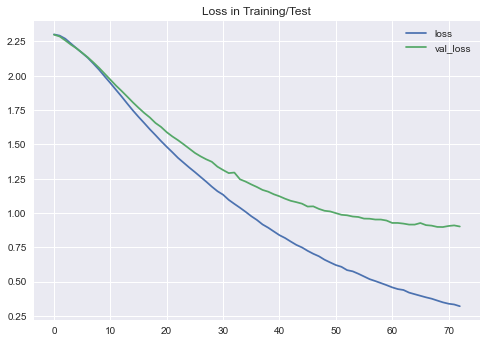

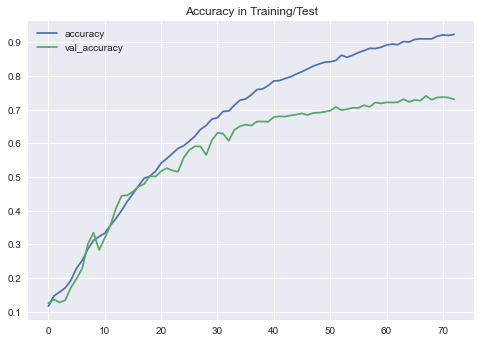

In [33]:
history = pd.DataFrame(history.history)
history[['loss', 'val_loss']].plot()
plt.title('Loss in Training/Test')
plt.plot()

history[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy in Training/Test')
plt.plot()


# Save the model

In [34]:
model.save(MODEL_PATH)

# Load the model from file and use it to make predictions

In [35]:
def load_model(model_path):
    if not os.path.exists(model_path):
        raise FileNotFoundError('Please train the model first.')
    model = tf.keras.models.load_model(model_path)
    return model

In [36]:
model = load_model(MODEL_PATH)
model

In [37]:
def predict(texts, model, tokenizer):
    # Preprocess
    padded = tokenize(texts, tokenizer)
    padded = np.array(padded, dtype='int32')

    # Make predictions
    predictions = model.predict(padded)
    predictions = [TOPICS[np.argmax(p)] for p in predictions]
    
    return predictions

In [38]:
inputs = test_texts
real = [TOPICS[l] for l in test_labels]
predictions = predict(inputs, model, tokenizer)

outputs = pd.DataFrame({
    'input': inputs,
    'real': real,
    'prediction': predictions
})

outputs['is_correct'] = outputs['real'] == outputs['prediction']

outputs

,input,real,prediction,is_correct
0,miami marlins hire kim ng mlb first female gen...,sports,sports,True
1,pretty great team work,sports,gaming,False
2,much better,gaming,gaming,True
3,date bobby boucher showed halftime mud dogs bo...,sports,travel,False
4,chemical romance announce full reunion tour,music,music,True
...,...,...,...,...
1980,britney spears called report victim conservato...,entertainment,politics,False
1981,view london eye,travel,travel,True
1982,parents force unremorseful kids apologize othe...,science,science,True
1983,american dream slowly fading away research ind...,science,science,True


In [39]:
# Save the model output to CSV

outputs.to_csv(PREDICTIONS_PATH, index=False)

Text(0.5, 1.0, 'True/False Predictions')

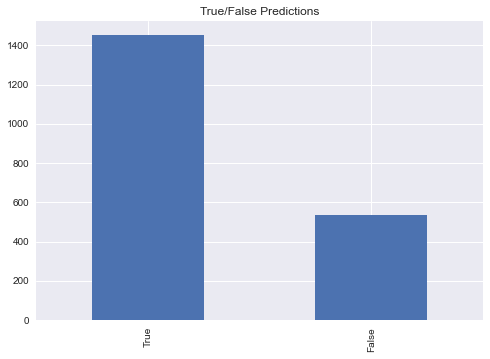

In [40]:
outputs.is_correct.value_counts().plot(kind='bar')
plt.title('True/False Predictions')

In [41]:
def predictions_by_group():
    results = {}

    for prediction, label in zip(predictions, real):
        if label not in results.keys():
            results.update({label: {'correct': 0, 'wrong': 0}})

        if label == prediction:
            results[label]['correct'] += 1
        else:
            results[label]['wrong'] += 1

    group_predictions = pd.DataFrame(results).T

    return group_predictions

<AxesSubplot:>

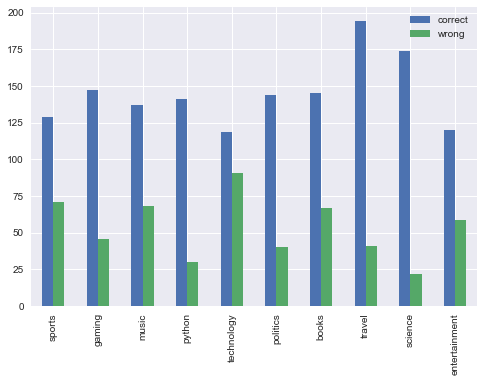

In [42]:
group_predictions = predictions_by_group()
group_predictions.plot(kind='bar')

In [43]:
group_predictions['accuracy'] = group_predictions['correct'] / (group_predictions['correct'] + group_predictions['wrong'])
group_predictions['accuracy'] = group_predictions['accuracy'].round(2)  # Round to 2 decimals
group_predictions

,correct,wrong,accuracy
sports,129,71,0.64
gaming,147,46,0.76
music,137,68,0.67
python,141,30,0.82
technology,119,91,0.57
politics,144,40,0.78
books,145,67,0.68
travel,194,41,0.83
science,174,22,0.89
entertainment,120,59,0.67


In [44]:
group_predictions.to_csv(GROUP_PREDICTIONS_PATH, index=True)

# More Evaluation Metrics

In [45]:
y_true = outputs['real'].to_numpy()
y_pred = outputs['prediction'].to_numpy()
labels = outputs['real'].unique()

In [46]:
def evaluate(y_true, y_pred, labels, average='macro'):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, labels=labels, average=average)
    recall = recall_score(y_true, y_pred, labels=labels, average=average)
    f1 = f1_score(y_true, y_pred, labels=labels, average=average)

    metrics = pd.Series([acc, precision, recall, f1], index=[
        'Accuracy', 'Precision', 'Recall', 'F1'
    ])

    return metrics

In [47]:
evaluate(y_true, y_pred, labels)

Accuracy     0.730479
Precision    0.753760
Recall       0.731643
F1           0.735052
dtype: float64